# Imports

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer




from sklearn.naive_bayes import MultinomialNB
import sklearn.metrics as metrics
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report,precision_score, recall_score,roc_curve, roc_auc_score, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder,StandardScaler, MinMaxScaler,LabelBinarizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier 
from sklearn.svm import SVC
from sklearn.utils import class_weight

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization,Flatten, Embedding, LSTM, GRU, Flatten
from tensorflow.keras.utils import to_categorical
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

tfidf = TfidfVectorizer(stop_words=set(stopwords.words('english')),max_features=500)
sid = SentimentIntensityAnalyzer()
scaler = StandardScaler()
lb = LabelBinarizer()
lemmatizer = WordNetLemmatizer()




# Helper functions/classes

In [4]:
class WordCloudGeneration:
    def preprocessing(self, data):
        data = data.split(".")
        # convert all words to lowercase
        data = [item.lower() for item in data]
        # load the stop_words of english
        stop_words = set(stopwords.words('english'))
        # concatenate all the data with spaces.
        paragraph = ' '.join(data)
        # tokenize the paragraph using the inbuilt tokenizer
        word_tokens = word_tokenize(paragraph) 
        # filter words present in stopwords list 
        preprocessed_data = ' '.join([word for word in word_tokens if not word in stop_words])
        return preprocessed_data

    def create_word_cloud(self, final_data,title=""):
        final_data=self.preprocessing(final_data)

        wordcloud = WordCloud(width=1600, height=800, max_font_size=200, background_color="white").generate(final_data)
        plt.figure(figsize=(12,10))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.title(title,fontsize=40)
        plt.show()

        
wordcloud_generator = WordCloudGeneration()

In [38]:
def show_metrics(true_vals,pred_vals):
    print(pd.DataFrame(confusion_matrix(true_vals,pred_vals),columns=["negative","neutral","positive"],index=["negative","neutral","positive"]))
    print("\n")
    print(classification_report(true_vals,pred_vals))
    show_roc(true_vals,pred_vals)

def show_roc(y_val,y_pred):
    lb.fit(y_val)
    y_val1 = lb.transform(y_val)
    y_pred1 = lb.transform(y_pred)
    print(f"WEIGHTED_ROC_AUC_SCORE: {roc_auc_score(y_val1, y_pred1, average='weighted'):.3f}")
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_val1[:, i], y_pred1[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    lw=2
    for i in range(3):
        plt.plot(fpr[i], tpr[i], lw=lw,
                label='ROC curve of class Model (area = {1:0.2f})'
                ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic of current Model')
    plt.legend(loc="lower right")
    plt.show()
    
def to_labels(series):
  le=LabelEncoder()
  return le.fit_transform(series)

def get_sentiment_scores(df):
    print("Calclating Polarity Scores - Reviews.text")
    df["reviews.text_scores"] = np.array(df["reviews.text"].map(lambda x: sid.polarity_scores(x)))
    print("Calclating Polarity Scores - Reviews.titl")
    df["reviews.title_scores"] = np.array(df["reviews.title"].map(lambda x: sid.polarity_scores(x)))
    neg=[]
    neu=[]
    pos=[]
    for scores in df["reviews.text_scores"]:
        neg.append(scores["neg"])
        neu.append(scores["neu"])
        pos.append(scores["pos"])
    df["reviews_text_neg"] = np.array(neg)
    df["reviews_text_neu"] = np.array(neu)
    df["reviews_text_pos"] = np.array(pos)
    df.drop(["reviews.text_scores","reviews.title_scores"],axis=1,inplace=True)
    
    print("Calclating Polarity Scores - Complete")

def get_tfidf(series):
    print("Calclating tfidf")

    new_series=[]
    for review in series:
        toks = word_tokenize(review)
        toks_sans_stopwords = [word for word in toks if not word in set(stopwords.words('english'))]
        review_lemma = lemmatizer.lemmatize(" ".join(toks_sans_stopwords))
        new_series.append(review_lemma)
    result=pd.DataFrame(tfidf.fit_transform(new_series).toarray())
    print("calculation complete")
    return result


# EDA

In [9]:
train_df = pd.read_csv("..\Datasets\Ecommerce\\train_data.csv")
test_df = pd.read_csv("..\Datasets\Ecommerce\\test_data.csv")
test_val_df = pd.read_csv("..\Datasets\Ecommerce\\test_data_hidden.csv")
print(f"Loading Datasets - {train_df.shape,test_df.shape}")

Loading Datasets - ((4000, 8), (1000, 7))


In [10]:
train_df.duplicated().sum(), test_df.duplicated().sum(), test_val_df.duplicated().sum()

(58, 3, 3)

Found existing duplicate data

In [11]:
train_df.describe()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
count,4000,4000,4000,4000,4000,4000,3990,4000
unique,23,1,23,4,638,3598,2606,3
top,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-23T00:00:00.000Z,I bought this kindle for my 11yr old granddaug...,Great tablet,Positive
freq,676,4000,628,2600,99,4,100,3749


In [12]:
train_df.dtypes

name                 object
brand                object
categories           object
primaryCategories    object
reviews.date         object
reviews.text         object
reviews.title        object
sentiment            object
dtype: object

In [13]:
test_df.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title
0,"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...",Amazon,"Fire Tablets,Computers/Tablets & Networking,Ta...",Electronics,2016-05-23T00:00:00.000Z,Amazon kindle fire has a lot of free app and c...,very handy device
1,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2018-01-02T00:00:00.000Z,The Echo Show is a great addition to the Amazo...,Another winner from Amazon
2,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-02T00:00:00.000Z,Great value from Best Buy. Bought at Christmas...,simple to use and reliable so far
3,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-03-25T00:00:00.000Z,"I use mine for email, Facebook ,games and to g...",Love it!!!
4,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2017-11-15T00:00:00.000Z,This is a fantastic item & the person I bought...,Fantastic!


In [14]:
test_df.describe()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title
count,1000,1000,1000,1000,1000,1000,997
unique,23,1,23,4,366,979,796
top,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-23T00:00:00.000Z,I bought the white version and have it in the ...,Great tablet
freq,169,1000,169,676,26,2,22


In [15]:
test_val_df.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...",Amazon,"Fire Tablets,Computers/Tablets & Networking,Ta...",Electronics,2016-05-23T00:00:00.000Z,Amazon kindle fire has a lot of free app and c...,very handy device,Positive
1,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2018-01-02T00:00:00.000Z,The Echo Show is a great addition to the Amazo...,Another winner from Amazon,Positive
2,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-02T00:00:00.000Z,Great value from Best Buy. Bought at Christmas...,simple to use and reliable so far,Positive
3,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-03-25T00:00:00.000Z,"I use mine for email, Facebook ,games and to g...",Love it!!!,Positive
4,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2017-11-15T00:00:00.000Z,This is a fantastic item & the person I bought...,Fantastic!,Positive


In [16]:
test_val_df.describe()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
count,1000,1000,1000,1000,1000,1000,997,1000
unique,23,1,23,4,366,979,796,3
top,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-23T00:00:00.000Z,I bought the white version and have it in the ...,Great tablet,Positive
freq,169,1000,169,676,26,2,22,937


In [17]:
train_df.isnull().sum()

name                  0
brand                 0
categories            0
primaryCategories     0
reviews.date          0
reviews.text          0
reviews.title        10
sentiment             0
dtype: int64

In [18]:
test_df.isnull().sum()

name                 0
brand                0
categories           0
primaryCategories    0
reviews.date         0
reviews.text         0
reviews.title        3
dtype: int64

Null values found in reviews.title   -  Fill fill with empty string

In [19]:
train_df["sentiment"].value_counts()

Positive    3749
Neutral      158
Negative      93
Name: sentiment, dtype: int64

Class Imbalance Problem - Will try oversampling, undersampling and classweights

In [20]:
Positive_Review_Text = ""
for review in  train_df[train_df["sentiment"]=="Positive"]["reviews.text"]:
  Positive_Review_Text += " " +review.lower()

Negative_Review_Text = ""
for review in  train_df[train_df["sentiment"]=="Negative"]["reviews.text"]:
  Negative_Review_Text += " " +review.lower()

Neutral_Review_Text = ""
for review in  train_df[train_df["sentiment"]=="Neutral"]["reviews.text"]:
  Neutral_Review_Text += " " +review.lower()


# Wordclouds

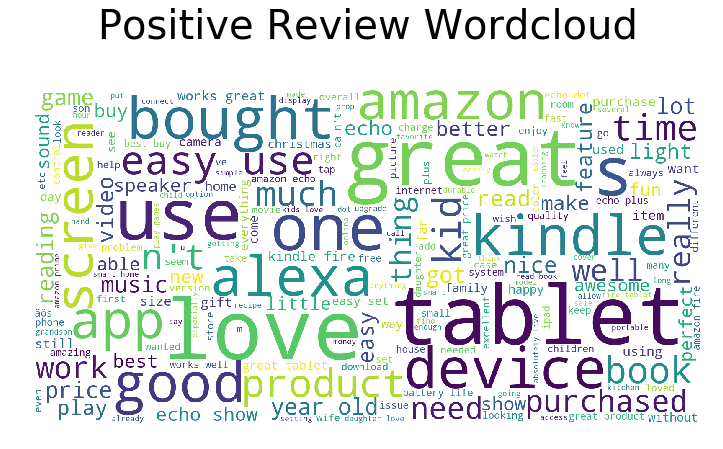

In [86]:

wordcloud_generator.create_word_cloud(Positive_Review_Text,"Positive Review Wordcloud\n")

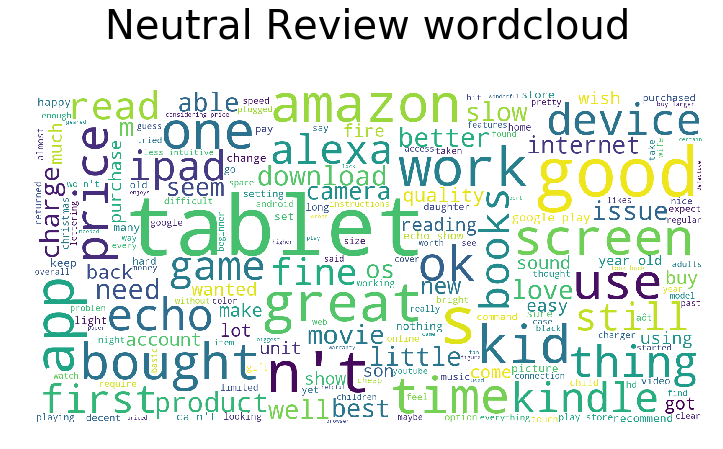

In [87]:
wordcloud_generator.create_word_cloud(Neutral_Review_Text,"Neutral Review wordcloud\n")

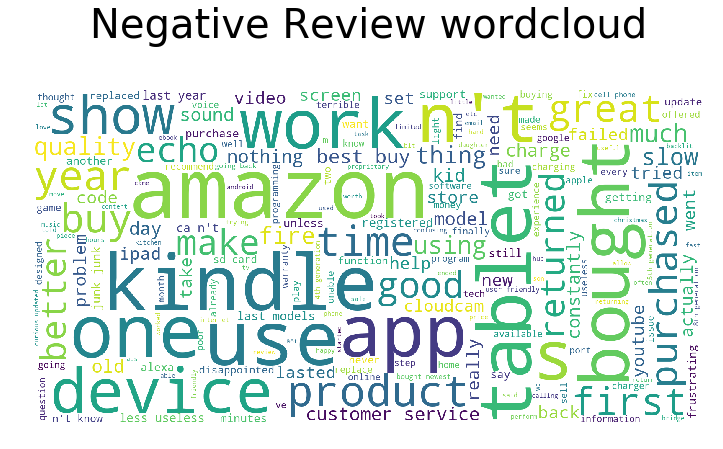

In [88]:
wordcloud_generator.create_word_cloud(Negative_Review_Text,"Negative Review wordcloud\n")

# Observations 

Duplicates found in all datasets


Only one brand. - brand column can be dropped:

name, categories, primaryCategories, and sentiment are categorical:
**LabelEncoder**

reviews.date to be converted to DateTime (Drop or not?):

reviews.text and reviews.title are text:
**TFIDF**
**Sentiment Analysis**

null values in reviews.title:


class imbalance issue:
**undersampling**
**oversampling**
**class weights**



# Tasks based on observations

Remove Duplicates

In [21]:
train_df=train_df[train_df.duplicated()==False]
test_df=test_df[test_df.duplicated()==False]
test_val_df=test_val_df[test_val_df.duplicated()==False]

train_df.reset_index(inplace=True)
test_val_df.reset_index(inplace=True)
test_df.reset_index(inplace=True)

fill null values

In [22]:
train_df['reviews.title'].fillna(value='',inplace=True)
test_val_df['reviews.title'].fillna(value=' ',inplace=True)
test_df['reviews.title'].fillna(value=' ',inplace=True)

Drop Brand Category

In [23]:
train_df.drop("brand",inplace=True,axis=1)
test_df.drop("brand",inplace=True,axis=1)
test_val_df.drop("brand",inplace=True,axis=1)

# Processing Data

Encode categories

In [24]:


categories = ["name","categories","primaryCategories","sentiment"]

for cat in categories:
  train_df[cat]=to_labels(train_df[cat])
  test_val_df[cat]=to_labels(test_val_df[cat])
  if not cat=="sentiment":
    test_df[cat]=to_labels(test_df[cat])


train_df.shape,test_df.shape,test_val_df.shape

((3942, 8), (997, 7), (997, 8))

Vectorize text with Tfidf

In [25]:
get_sentiment_scores(train_df)
get_sentiment_scores(test_df)
get_sentiment_scores(test_val_df)

train_df=pd.concat((train_df,get_tfidf(train_df["reviews.text"])),axis=1).drop("reviews.text",axis=1)
test_df=pd.concat((test_df,get_tfidf(test_df["reviews.text"])),axis=1).drop("reviews.text",axis=1)
test_val_df=pd.concat((test_val_df,get_tfidf(test_val_df["reviews.text"])),axis=1).drop("reviews.text",axis=1)

train_df=pd.concat((train_df,get_tfidf(train_df["reviews.title"])),axis=1).drop("reviews.title",axis=1)
test_df=pd.concat((test_df,get_tfidf(test_df["reviews.title"])),axis=1).drop("reviews.title",axis=1)
test_val_df=pd.concat((test_val_df,get_tfidf(test_val_df["reviews.title"])),axis=1).drop("reviews.title",axis=1)

train_df.shape,test_df.shape,test_val_df.shape

Calclating Polarity Scores - Reviews.text
Calclating Polarity Scores - Reviews.titl
Calclating Polarity Scores - Complete
Calclating Polarity Scores - Reviews.text
Calclating Polarity Scores - Reviews.titl
Calclating Polarity Scores - Complete
Calclating Polarity Scores - Reviews.text
Calclating Polarity Scores - Reviews.titl
Calclating Polarity Scores - Complete
Calclating tfidf
calculation complete
Calclating tfidf
calculation complete
Calclating tfidf
calculation complete
Calclating tfidf
calculation complete
Calclating tfidf
calculation complete
Calclating tfidf
calculation complete


((3942, 1009), (997, 1008), (997, 1009))

In [26]:

train_df['reviews.date'] = train_df['reviews.date'].str.split('T').str[0]
test_val_df['reviews.date'] = test_val_df['reviews.date'].str.split('T').str[0]
test_df['reviews.date'] = test_df['reviews.date'].str.split('T').str[0]

train_df['reviews_day'] = pd.to_datetime(train_df['reviews.date'], format='%Y-%m-%d').dt.day
train_df['reviews_month'] = pd.to_datetime(train_df['reviews.date'], format='%Y-%m-%d').dt.month
train_df['reviews_year'] = pd.to_datetime(train_df['reviews.date'], format='%Y-%m-%d').dt.year

test_val_df['reviews_day'] = pd.to_datetime(test_val_df['reviews.date'], format='%Y-%m-%d').dt.day
test_val_df['reviews_month'] = pd.to_datetime(test_val_df['reviews.date'], format='%Y-%m-%d').dt.month
test_val_df['reviews_year'] = pd.to_datetime(test_val_df['reviews.date'], format='%Y-%m-%d').dt.year

test_df['reviews_day'] = pd.to_datetime(test_df['reviews.date'], format='%Y-%m-%d').dt.day
test_df['reviews_month'] = pd.to_datetime(test_df['reviews.date'], format='%Y-%m-%d').dt.month
test_df['reviews_year'] = pd.to_datetime(test_df['reviews.date'], format='%Y-%m-%d').dt.year


In [27]:

X_train = np.array(train_df.drop(["sentiment","reviews.date","index"],axis=1))


y_train = np.array(train_df["sentiment"])
y_test = np.array(test_val_df["sentiment"])

X_test = np.array(test_val_df.drop(["reviews.date","sentiment","index"],axis=1))
print(X_test.shape,y_test.shape,X_train.shape,y_train.shape)

(997, 1009) (997,) (3942, 1009) (3942,)


In [28]:
X_train = X_train.astype(np.float16)

Cast to float16 to ease computational load for gpu

In [29]:
test_val_df.drop(["reviews.date","index"],axis=1, inplace=True)

# Multinomial Naive Bayes Classification on unchanged data


In [30]:
model = MultinomialNB()

In [31]:
model.fit(X_train,y_train)

MultinomialNB()

In [32]:
preds=model.predict(X_test)

          negative  neutral  positive
negative         0        0        24
neutral          0        0        39
positive         0       22       912


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.00      0.00      0.00        39
           2       0.94      0.98      0.96       934

    accuracy                           0.91       997
   macro avg       0.31      0.33      0.32       997
weighted avg       0.88      0.91      0.90       997

WEIGHTED_ROC_AUC_SCORE: 0.489


C:\Users\perry\.conda\envs\nlp_course\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


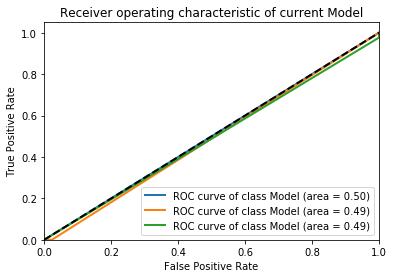

In [39]:
show_metrics(y_test,preds)

We can see that with the imbalanced class the model is basically ineffectual at predicting the classes

# Dealing with class Imbalance

### generate class weights

In [46]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(y_train),
                                                 y=y_train)
class_weights={0:class_weights[0],1:class_weights[1],2:class_weights[2]}


### Generate oversampling and undersampling tools

In [47]:
oversample=RandomOverSampler(sampling_strategy="not majority")
undersample=RandomUnderSampler(sampling_strategy="not minority")

# Trying models with oversampled/undersampled data

### Defining Models to test

In [43]:
models=[
        LogisticRegression(class_weight='balanced'),
        SVC(class_weight='balanced'),
        DecisionTreeClassifier(class_weight='balanced'),
        RandomForestClassifier(class_weight='balanced'),
        MultinomialNB(),
        XGBClassifier()
        ]


## Testing Models

Using only base models with class_weights to start, Will fine tune the two most promising results

Using ROC_AUC Score as defining metric

### Control Group

LogisticRegression(class_weight='balanced')  -- control 
 ************************************************** 



C:\Users\perry\.conda\envs\nlp_course\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


          negative  neutral  positive
negative        14        5         5
neutral         13       12        14
positive       261      283       390


              precision    recall  f1-score   support

           0       0.05      0.58      0.09        24
           1       0.04      0.31      0.07        39
           2       0.95      0.42      0.58       934

    accuracy                           0.42       997
   macro avg       0.35      0.44      0.25       997
weighted avg       0.90      0.42      0.55       997

WEIGHTED_ROC_AUC_SCORE: 0.558


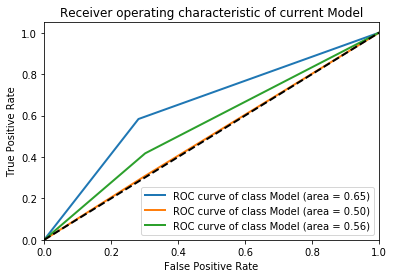

SVC(class_weight='balanced')  -- control 
 ************************************************** 

          negative  neutral  positive
negative         0        0        24
neutral          0        0        39
positive         0        0       934


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.00      0.00      0.00        39
           2       0.94      1.00      0.97       934

    accuracy                           0.94       997
   macro avg       0.31      0.33      0.32       997
weighted avg       0.88      0.94      0.91       997

WEIGHTED_ROC_AUC_SCORE: 0.500


C:\Users\perry\.conda\envs\nlp_course\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


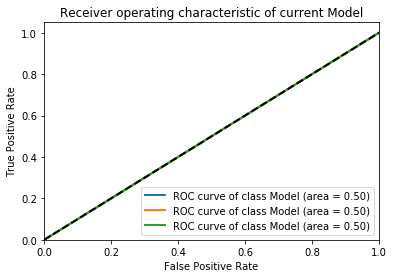

DecisionTreeClassifier(class_weight='balanced')  -- control 
 ************************************************** 

          negative  neutral  positive
negative         7        3        14
neutral          8        5        26
positive        77       57       800


              precision    recall  f1-score   support

           0       0.08      0.29      0.12        24
           1       0.08      0.13      0.10        39
           2       0.95      0.86      0.90       934

    accuracy                           0.81       997
   macro avg       0.37      0.43      0.37       997
weighted avg       0.90      0.81      0.85       997

WEIGHTED_ROC_AUC_SCORE: 0.608


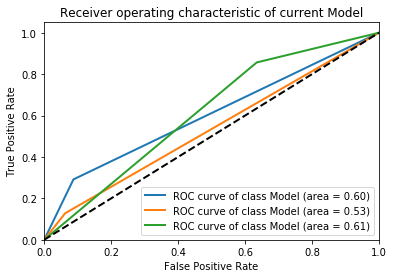

RandomForestClassifier(class_weight='balanced')  -- control 
 ************************************************** 

          negative  neutral  positive
negative         1        0        23
neutral          0        0        39
positive         0        0       934


              precision    recall  f1-score   support

           0       1.00      0.04      0.08        24
           1       0.00      0.00      0.00        39
           2       0.94      1.00      0.97       934

    accuracy                           0.94       997
   macro avg       0.65      0.35      0.35       997
weighted avg       0.90      0.94      0.91       997

WEIGHTED_ROC_AUC_SCORE: 0.508


C:\Users\perry\.conda\envs\nlp_course\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


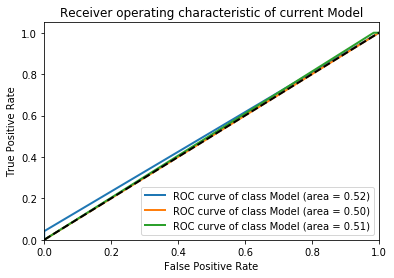

MultinomialNB()  -- control 
 ************************************************** 

          negative  neutral  positive
negative         0        0        24
neutral          0        0        39
positive         0       22       912


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.00      0.00      0.00        39
           2       0.94      0.98      0.96       934

    accuracy                           0.91       997
   macro avg       0.31      0.33      0.32       997
weighted avg       0.88      0.91      0.90       997

WEIGHTED_ROC_AUC_SCORE: 0.489


C:\Users\perry\.conda\envs\nlp_course\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


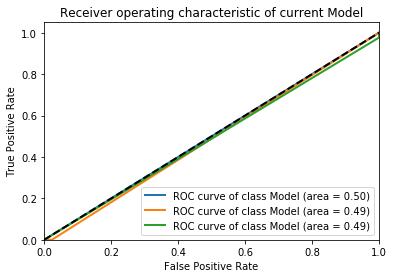

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None)  -- control 
 ************************************************** 

[08:40:18] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old beha

C:\Users\perry\.conda\envs\nlp_course\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


          negative  neutral  positive
negative         5        2        17
neutral          2        2        35
positive         3        8       923


              precision    recall  f1-score   support

           0       0.50      0.21      0.29        24
           1       0.17      0.05      0.08        39
           2       0.95      0.99      0.97       934

    accuracy                           0.93       997
   macro avg       0.54      0.42      0.45       997
weighted avg       0.91      0.93      0.92       997

WEIGHTED_ROC_AUC_SCORE: 0.580


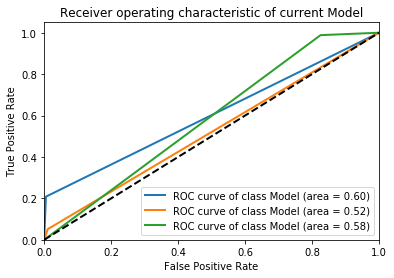

In [44]:
for model in models:
    print(model," -- control","\n","*"*50,"\n")

    model.fit(X_train,y_train)
    preds = model.predict(X_test)
    show_metrics(y_test,preds)

Highest AUC_ROC:Decision Tree .608

Results are all over the place. Not efficient at predicting classes.

### Oversampled Data

LogisticRegression(class_weight='balanced')  -- oversampled 
 ************************************************** 



C:\Users\perry\.conda\envs\nlp_course\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


          negative  neutral  positive
negative        15        5         4
neutral         13       13        13
positive       305      294       335


              precision    recall  f1-score   support

           0       0.05      0.62      0.08        24
           1       0.04      0.33      0.07        39
           2       0.95      0.36      0.52       934

    accuracy                           0.36       997
   macro avg       0.35      0.44      0.23       997
weighted avg       0.89      0.36      0.49       997

WEIGHTED_ROC_AUC_SCORE: 0.546


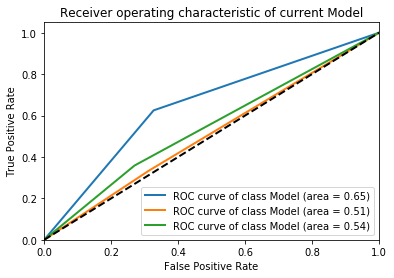

SVC(class_weight='balanced')  -- oversampled 
 ************************************************** 

          negative  neutral  positive
negative         8        7         9
neutral          9       12        18
positive       228      285       421


              precision    recall  f1-score   support

           0       0.03      0.33      0.06        24
           1       0.04      0.31      0.07        39
           2       0.94      0.45      0.61       934

    accuracy                           0.44       997
   macro avg       0.34      0.36      0.25       997
weighted avg       0.88      0.44      0.57       997

WEIGHTED_ROC_AUC_SCORE: 0.512


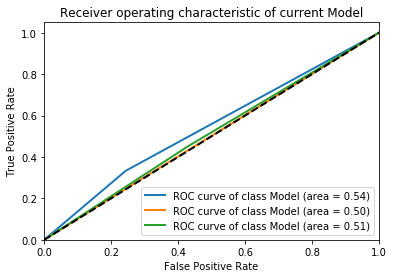

DecisionTreeClassifier(class_weight='balanced')  -- oversampled 
 ************************************************** 

          negative  neutral  positive
negative        10        3        11
neutral          9        7        23
positive        95       68       771


              precision    recall  f1-score   support

           0       0.09      0.42      0.14        24
           1       0.09      0.18      0.12        39
           2       0.96      0.83      0.89       934

    accuracy                           0.79       997
   macro avg       0.38      0.47      0.38       997
weighted avg       0.90      0.79      0.84       997

WEIGHTED_ROC_AUC_SCORE: 0.640


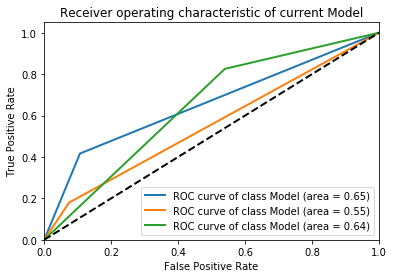

RandomForestClassifier(class_weight='balanced')  -- oversampled 
 ************************************************** 

          negative  neutral  positive
negative         6        0        18
neutral          0        0        39
positive         6        0       928


              precision    recall  f1-score   support

           0       0.50      0.25      0.33        24
           1       0.00      0.00      0.00        39
           2       0.94      0.99      0.97       934

    accuracy                           0.94       997
   macro avg       0.48      0.41      0.43       997
weighted avg       0.89      0.94      0.91       997

WEIGHTED_ROC_AUC_SCORE: 0.545


C:\Users\perry\.conda\envs\nlp_course\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


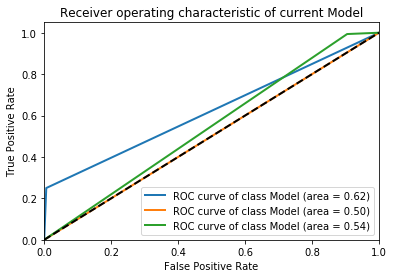

MultinomialNB()  -- oversampled 
 ************************************************** 

          negative  neutral  positive
negative         6        3        15
neutral          5        5        29
positive        76      134       724


              precision    recall  f1-score   support

           0       0.07      0.25      0.11        24
           1       0.04      0.13      0.06        39
           2       0.94      0.78      0.85       934

    accuracy                           0.74       997
   macro avg       0.35      0.38      0.34       997
weighted avg       0.89      0.74      0.80       997

WEIGHTED_ROC_AUC_SCORE: 0.538


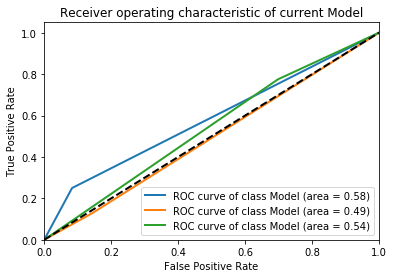

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)  -- oversampled 
 ************************************************** 



C:\Users\perry\.conda\envs\nlp_course\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:48:47] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
          negative  neutral  positive
negative         9        3        12
neutral          5       11        23
positive        23       48       863


              precision    recall  f1-score   support

           0       0.24      0.38      0.30        24
           1       0.18      0.28      0.22        39
           2       0.96      0.92      0.94       934

    accuracy                           0.89       997
   macro avg       0.46      0.53      0.49       997
weighted avg       0.91      0.89      0.90       997

WEIGHTED_ROC_AUC_SCORE: 0.681


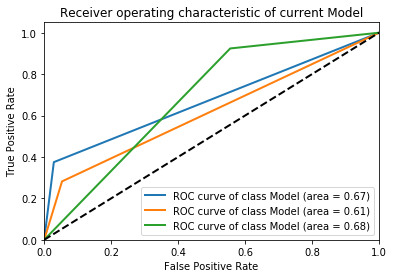

In [48]:
for model in models:
    print(model," -- oversampled","\n","*"*50,"\n")
    steps = [("o",oversample),('model', model)]
    pipeline = Pipeline(steps=steps)
    pipeline.fit(X_train,y_train)
    preds = pipeline.predict(X_test)
    show_metrics(y_test,preds)

Highest AUC_ROC's:XGBClassifier .681, Decision Tree .640

Predictive capabilities of top models on oversampled data has noticeably increased.

### Undersampled

LogisticRegression(class_weight='balanced')  -- undersampled 
 ************************************************** 



C:\Users\perry\.conda\envs\nlp_course\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


          negative  neutral  positive
negative        12        8         4
neutral         14       14        11
positive       176      341       417


              precision    recall  f1-score   support

           0       0.06      0.50      0.11        24
           1       0.04      0.36      0.07        39
           2       0.97      0.45      0.61       934

    accuracy                           0.44       997
   macro avg       0.35      0.44      0.26       997
weighted avg       0.91      0.44      0.58       997

WEIGHTED_ROC_AUC_SCORE: 0.601


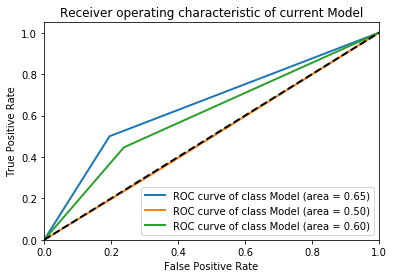

SVC(class_weight='balanced')  -- undersampled 
 ************************************************** 

          negative  neutral  positive
negative         6        7        11
neutral          8        9        22
positive       193      249       492


              precision    recall  f1-score   support

           0       0.03      0.25      0.05        24
           1       0.03      0.23      0.06        39
           2       0.94      0.53      0.67       934

    accuracy                           0.51       997
   macro avg       0.33      0.34      0.26       997
weighted avg       0.88      0.51      0.64       997

WEIGHTED_ROC_AUC_SCORE: 0.501


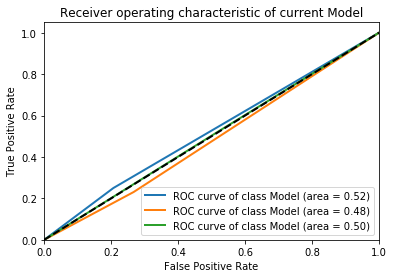

DecisionTreeClassifier(class_weight='balanced')  -- undersampled 
 ************************************************** 

          negative  neutral  positive
negative        15        7         2
neutral         14       16         9
positive       192      296       446


              precision    recall  f1-score   support

           0       0.07      0.62      0.12        24
           1       0.05      0.41      0.09        39
           2       0.98      0.48      0.64       934

    accuracy                           0.48       997
   macro avg       0.36      0.50      0.28       997
weighted avg       0.92      0.48      0.61       997

WEIGHTED_ROC_AUC_SCORE: 0.649


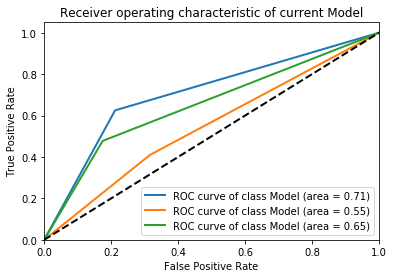

RandomForestClassifier(class_weight='balanced')  -- undersampled 
 ************************************************** 

          negative  neutral  positive
negative        18        6         0
neutral         19        8        12
positive       146      201       587


              precision    recall  f1-score   support

           0       0.10      0.75      0.17        24
           1       0.04      0.21      0.06        39
           2       0.98      0.63      0.77       934

    accuracy                           0.61       997
   macro avg       0.37      0.53      0.33       997
weighted avg       0.92      0.61      0.72       997

WEIGHTED_ROC_AUC_SCORE: 0.712


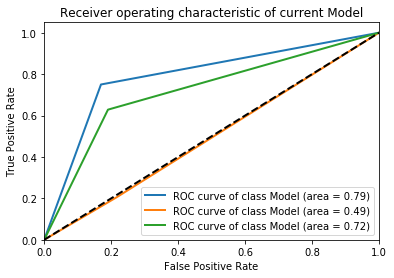

MultinomialNB()  -- undersampled 
 ************************************************** 

          negative  neutral  positive
negative         6        9         9
neutral          6       15        18
positive       140      382       412


              precision    recall  f1-score   support

           0       0.04      0.25      0.07        24
           1       0.04      0.38      0.07        39
           2       0.94      0.44      0.60       934

    accuracy                           0.43       997
   macro avg       0.34      0.36      0.25       997
weighted avg       0.88      0.43      0.57       997

WEIGHTED_ROC_AUC_SCORE: 0.507


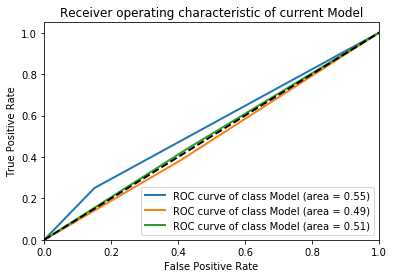

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)  -- undersampled 
 ************************************************** 

[08:53:13] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old be

C:\Users\perry\.conda\envs\nlp_course\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


          negative  neutral  positive
negative        17        6         1
neutral         12       19         8
positive        94      372       468


              precision    recall  f1-score   support

           0       0.14      0.71      0.23        24
           1       0.05      0.49      0.09        39
           2       0.98      0.50      0.66       934

    accuracy                           0.51       997
   macro avg       0.39      0.57      0.33       997
weighted avg       0.92      0.51      0.63       997

WEIGHTED_ROC_AUC_SCORE: 0.677


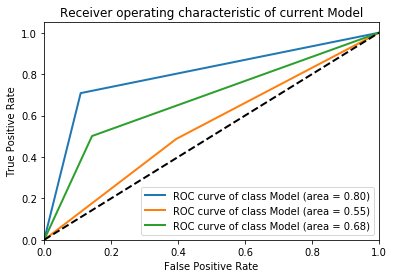

In [49]:
for model in models:
    print(model," -- undersampled","\n","*"*50,"\n")
    steps = [("o",undersample),('model', model)]
    pipeline = Pipeline(steps=steps)
    pipeline.fit(X_train,y_train)
    preds = pipeline.predict(X_test)
    show_metrics(y_test,preds)

Highest AUC_ROC's: Random Forest .701, XGB .677, 

Significant improvement in pedictive capability. Difficulties in identifying neutral reviews.

### Over/under

LogisticRegression(class_weight='balanced')  -- over/under 
 ************************************************** 



C:\Users\perry\.conda\envs\nlp_course\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


          negative  neutral  positive
negative        16        3         5
neutral         13       11        15
positive       284      259       391


              precision    recall  f1-score   support

           0       0.05      0.67      0.09        24
           1       0.04      0.28      0.07        39
           2       0.95      0.42      0.58       934

    accuracy                           0.42       997
   macro avg       0.35      0.46      0.25       997
weighted avg       0.89      0.42      0.55       997

WEIGHTED_ROC_AUC_SCORE: 0.552


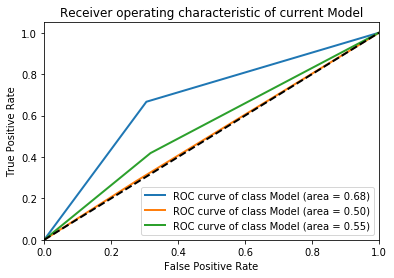

SVC(class_weight='balanced')  -- over/under 
 ************************************************** 

          negative  neutral  positive
negative         5        9        10
neutral         12       12        15
positive       230      293       411


              precision    recall  f1-score   support

           0       0.02      0.21      0.04        24
           1       0.04      0.31      0.07        39
           2       0.94      0.44      0.60       934

    accuracy                           0.43       997
   macro avg       0.33      0.32      0.23       997
weighted avg       0.89      0.43      0.57       997

WEIGHTED_ROC_AUC_SCORE: 0.520


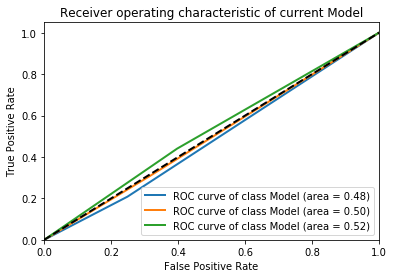

DecisionTreeClassifier(class_weight='balanced')  -- over/under 
 ************************************************** 

          negative  neutral  positive
negative        11        4         9
neutral          4       10        25
positive        83       79       772


              precision    recall  f1-score   support

           0       0.11      0.46      0.18        24
           1       0.11      0.26      0.15        39
           2       0.96      0.83      0.89       934

    accuracy                           0.80       997
   macro avg       0.39      0.51      0.41       997
weighted avg       0.90      0.80      0.84       997

WEIGHTED_ROC_AUC_SCORE: 0.642


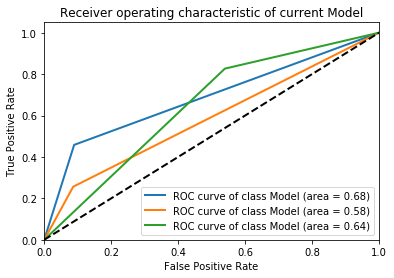

RandomForestClassifier(class_weight='balanced')  -- over/under 
 ************************************************** 

          negative  neutral  positive
negative         2        0        22
neutral          0        0        39
positive         4        1       929


              precision    recall  f1-score   support

           0       0.33      0.08      0.13        24
           1       0.00      0.00      0.00        39
           2       0.94      0.99      0.97       934

    accuracy                           0.93       997
   macro avg       0.42      0.36      0.37       997
weighted avg       0.89      0.93      0.91       997

WEIGHTED_ROC_AUC_SCORE: 0.513


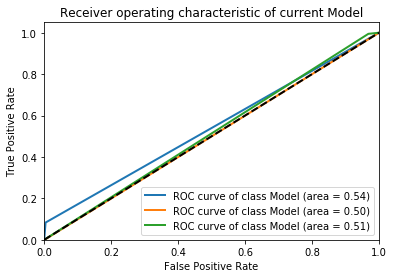

MultinomialNB()  -- over/under 
 ************************************************** 

          negative  neutral  positive
negative         6        3        15
neutral          3        8        28
positive        74      139       721


              precision    recall  f1-score   support

           0       0.07      0.25      0.11        24
           1       0.05      0.21      0.08        39
           2       0.94      0.77      0.85       934

    accuracy                           0.74       997
   macro avg       0.36      0.41      0.35       997
weighted avg       0.89      0.74      0.80       997

WEIGHTED_ROC_AUC_SCORE: 0.545


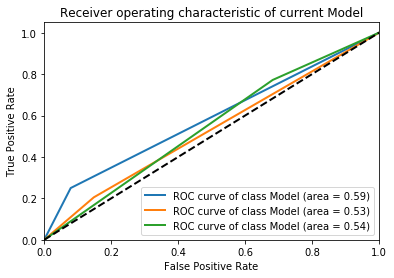

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)  -- over/under 
 ************************************************** 



C:\Users\perry\.conda\envs\nlp_course\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:01:02] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
          negative  neutral  positive
negative         9        6         9
neutral          6        7        26
positive        28       41       865


              precision    recall  f1-score   support

           0       0.21      0.38      0.27        24
           1       0.13      0.18      0.15        39
           2       0.96      0.93      0.94       934

    accuracy                           0.88       997
   macro avg       0.43      0.49      0.45       997
weighted avg       0.91      0.88      0.90       997

WEIGHTED_ROC_AUC_SCORE: 0.680


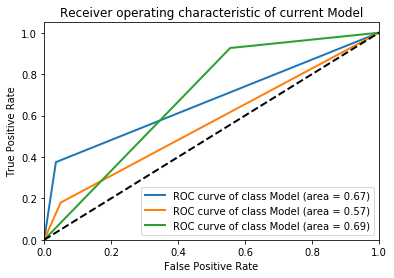

In [50]:
for model in models:
    print(model," -- over/under","\n","*"*50,"\n")
    steps = [("o",oversample),("u", undersample),('model', model)]
    pipeline = Pipeline(steps=steps)
    pipeline.fit(X_train,y_train)
    preds = pipeline.predict(X_test)
    show_metrics(y_test,preds)

Highest AUC_ROC:XGB .680

No predictive improvements

### Comparing individual model performance with Voting classifier using undersampled data and two highest performing models

C:\Users\perry\.conda\envs\nlp_course\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:09:33] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
          negative  neutral  positive
negative        18        6         0
neutral         11       19         9
positive        97      299       538


              precision    recall  f1-score   support

           0       0.14      0.75      0.24        24
           1       0.06      0.49      0.10        39
           2       0.98      0.58      0.73       934

    accuracy                           0.58       997
   macro avg       0.40      0.60      0.36       997
weighted avg       0.93      0.58      0.69       997

WEIGHTED_ROC_AUC_SCORE: 0.714


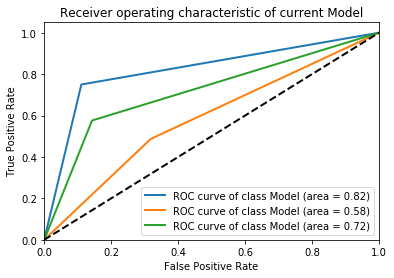

          negative  neutral  positive
negative        20        2         2
neutral         13       14        12
positive       102      217       615


              precision    recall  f1-score   support

           0       0.15      0.83      0.25        24
           1       0.06      0.36      0.10        39
           2       0.98      0.66      0.79       934

    accuracy                           0.65       997
   macro avg       0.40      0.62      0.38       997
weighted avg       0.92      0.65      0.75       997

WEIGHTED_ROC_AUC_SCORE: 0.715


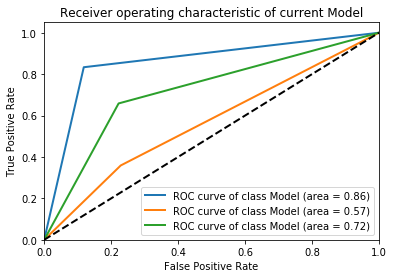

C:\Users\perry\.conda\envs\nlp_course\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:09:39] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
          negative  neutral  positive
negative        21        3         0
neutral         21       12         6
positive       202      371       361


              precision    recall  f1-score   support

           0       0.09      0.88      0.16        24
           1       0.03      0.31      0.06        39
           2       0.98      0.39      0.55       934

    accuracy                           0.40       997
   macro avg       0.37      0.52      0.26       997
weighted avg       0.92      0.40      0.53       997

WEIGHTED_ROC_AUC_SCORE: 0.643


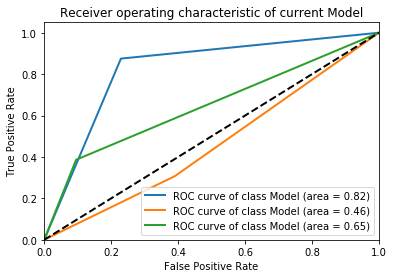

In [54]:
bestModels = [
  ("XGB", XGBClassifier(n_estimators=1000,max_depth=6)),
  ("FRST", RandomForestClassifier(class_weight="balanced"))
]

for model in bestModels:
  steps = [("u",undersample),model]
  pipeline = Pipeline(steps=steps)
  pipeline.fit(X_train,y_train)
  preds = pipeline.predict(X_test)
  show_metrics(y_test,preds)

steps = [("u",undersample),('model', VotingClassifier(bestModels))]
pipeline = Pipeline(steps=steps)
pipeline.fit(X_train,y_train)
preds = pipeline.predict(X_test)
show_metrics(y_test,preds)



Random Forest and XGB perform comparably with ROC SCORE of and .714 and .715 respectively.

The voting classifier shows poor performance at predicting the neutral reviews.

# Finetuning top ML models


# Simple ANN

In [62]:
from tensorflow.keras.callbacks import EarlyStopping
es=EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=2,
    mode='auto',
    baseline=None,
    restore_best_weights=True,)


In [63]:
NN= Sequential()
NN.add(Flatten())
NN.add(Dense(128, activation="relu"))
NN.add(Dropout(.4))
NN.add(Dense(256,activation="relu"))
NN.add(Dropout(.4))
NN.add(Dense(512,activation="relu"))

NN.add(Dropout(.4))
NN.add(Dense(3,activation="softmax"))
NN.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["acc"])

In [64]:

NN.fit(X_train,y_train,epochs=100, validation_data=[X_test,y_test],callbacks=[es], class_weight=class_weights)

Train on 3942 samples, validate on 997 samples
Epoch 1/100
3942/3942 [==============================] - 2s 416us/sample - loss: 39.2432 - acc: 0.3409 - val_loss: 61.6594 - val_acc: 1.0000
Epoch 2/100
3942/3942 [==============================] - 1s 217us/sample - loss: 37.6119 - acc: 0.9444 - val_loss: 61.6594 - val_acc: 1.0000
Epoch 3/100
3942/3942 [==============================] - 1s 204us/sample - loss: 37.2779 - acc: 1.0000 - val_loss: 61.6594 - val_acc: 1.0000
Epoch 4/100
3942/3942 [==============================] - 1s 226us/sample - loss: 37.5471 - acc: 1.0000 - val_loss: 61.6594 - val_acc: 1.0000
Epoch 5/100
3942/3942 [==============================] - 1s 218us/sample - loss: 37.8458 - acc: 1.0000 - val_loss: 61.6594 - val_acc: 1.0000
Epoch 6/100
3942/3942 [==============================] - 1s 207us/sample - loss: 38.2004 - acc: 0.9997 - val_loss: 61.6594 - val_acc: 1.0000
Epoch 7/100
3942/3942 [==============================] - 1s 213us/sample - loss: 38.0769 - acc: 1.0000 - va

In [65]:
preds_array = NN.predict(X_test)
pred_list = []
for i,pred in enumerate(preds_array):
    pred_list.append(pred.argmax())

          negative  neutral  positive
negative        24        0         0
neutral         39        0         0
positive       934        0         0


              precision    recall  f1-score   support

           0       0.02      1.00      0.05        24
           1       0.00      0.00      0.00        39
           2       0.00      0.00      0.00       934

    accuracy                           0.02       997
   macro avg       0.01      0.33      0.02       997
weighted avg       0.00      0.02      0.00       997

WEIGHTED_ROC_AUC_SCORE: 0.500


C:\Users\perry\.conda\envs\nlp_course\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


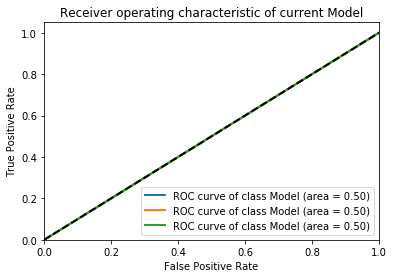

In [66]:
show_metrics(y_test,pred_list)

ANN predicts all reviews as positive - Not useful in this regard

# Using LSTM to predict classes

In [77]:
y_train2 = label_binarize(y_train, classes=[0, 1, 2])
y_test2 = label_binarize(y_test, classes=[0,1,2])
epochs = 100
emb_dim = 128
batch_size = 256

In [87]:
model = Sequential()
model.add(Embedding(X_train.shape[0], emb_dim, input_length=X_train.shape[1]))
model.add(LSTM(16, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["acc"])

Train on 3942 samples, validate on 997 samples
Epoch 1/100
3942/3942 [==============================] - 47s 12ms/sample - loss: 1.0994 - acc: 0.2207 - val_loss: 1.1016 - val_acc: 0.1334
Epoch 2/100
3942/3942 [==============================] - 44s 11ms/sample - loss: 1.0985 - acc: 0.4688 - val_loss: 1.0771 - val_acc: 0.7011
Epoch 3/100
3942/3942 [==============================] - 45s 11ms/sample - loss: 1.0950 - acc: 0.5155 - val_loss: 1.0885 - val_acc: 0.2959
Epoch 4/100
3942/3942 [==============================] - 46s 12ms/sample - loss: 1.0918 - acc: 0.6045 - val_loss: 1.0628 - val_acc: 0.6921
Epoch 5/100
3942/3942 [==============================] - 48s 12ms/sample - loss: 1.0890 - acc: 0.5726 - val_loss: 1.0751 - val_acc: 0.4333
Epoch 6/100
3942/3942 [==============================] - 45s 11ms/sample - loss: 1.0879 - acc: 0.4300 - val_loss: 1.0865 - val_acc: 0.3059
Epoch 7/100
3942/3942 [==============================] - 45s 11ms/sample - loss: 1.0829 - acc: 0.3425 - val_loss: 1.092

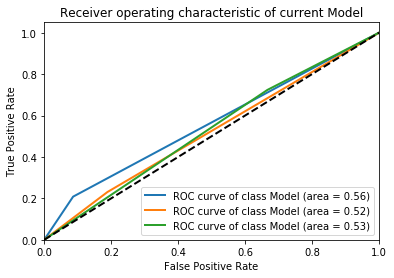

In [88]:
model.fit(X_train, y_train2, epochs=epochs, batch_size=batch_size, class_weight=class_weights, validation_data=[X_test,y_test2], callbacks=[es])
preds = model.predict(X_test, batch_size=100)
preds = np.argmax(preds, axis=1)
show_metrics(y_test, preds)

# Using GRU to predict classes

In [90]:
model = Sequential()
model.add(Embedding(X_train.shape[0], emb_dim, input_length=X_train.shape[1]))
model.add(GRU(16, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["acc"])


Train on 3942 samples, validate on 997 samples
Epoch 1/100
3942/3942 [==============================] - 36s 9ms/sample - loss: 1.1006 - acc: 0.4911 - val_loss: 1.0699 - val_acc: 0.7643
Epoch 2/100
3942/3942 [==============================] - 34s 9ms/sample - loss: 1.0954 - acc: 0.5794 - val_loss: 1.0789 - val_acc: 0.4243
Epoch 3/100
3942/3942 [==============================] - 35s 9ms/sample - loss: 1.0916 - acc: 0.4749 - val_loss: 1.0757 - val_acc: 0.4804
Epoch 4/100
3942/3942 [==============================] - 34s 9ms/sample - loss: 1.0892 - acc: 0.4351 - val_loss: 1.0645 - val_acc: 0.4794
Epoch 5/100
3942/3942 [==============================] - 35s 9ms/sample - loss: 1.0842 - acc: 0.5289 - val_loss: 1.0491 - val_acc: 0.5165
Epoch 6/100
3942/3942 [==============================] - 34s 9ms/sample - loss: 1.0826 - acc: 0.5599 - val_loss: 1.0418 - val_acc: 0.5186
Epoch 7/100
3942/3942 [==============================] - 33s 8ms/sample - loss: 1.0769 - acc: 0.5180 - val_loss: 1.0515 - val

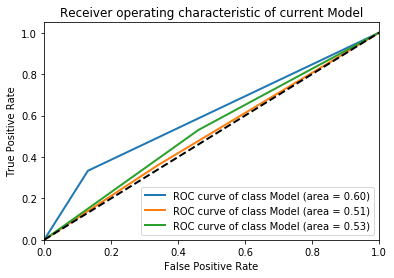

In [91]:
model.fit(X_train, y_train2, epochs=epochs, batch_size=batch_size, class_weight=class_weights, validation_data=[X_test,y_test2], callbacks=[es])
preds = model.predict(X_test, batch_size=100)
preds = np.argmax(preds, axis=1)
show_metrics(y_test, preds)

<function sklearn.metrics._ranking.auc(x, y)>